# Purpose
The purpose of this notebook is to empirically check that
$$\sum_{i=1}^n \mathbb{V}[Z_{i,t}] = \mathbb{V}\left[\sum_{i=1}^n Z_{i,t}\right]$$
That is, whether the $Z_{it}$ are independent across i.

$$\begin{align*}
Z_{it} &= \sum_{j=1}^k(y_{ij} - \hat Y^{\leq t}_{ij})^2\\
    &= \sum_{j=1}^k(y_{ij} - \frac{1}{t}\sum_{s=1}^t\hat Y^s_{ij})^2\\
    &= \sum_{j=1}^k(y_{ij} - \frac{1}{t}\sum_{s=1}^t \widehat{\mathit{tree}}^s(X_i)_j)^2\\
\end{align*}$$

In [1]:
from sklearn.datasets import fetch_openml, make_classification

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import itertools as it
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [90]:
def get_random_dataset(n, d, k):
    
    X = np.random.rand(n, d)
    y = np.random.randint(0, k, n)
    
    return X, y

def get_one_hot_encoding(y):
    y_onehot = np.zeros((len(y), k))
    for label in range(k):
        mask = y == label
        y_onehot[mask, label] = 1
    return y_onehot

d = 2
k = 2
X, y = get_random_dataset(1000, d=d, k=k)

    
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=0, test_size=0.5)

## Case 1: Test data is fixed and different forests are used to predict over them
Here, randomness in $Z_{it}$ is introduced by the training process of the forest *only*. 

$Z_{it} = f(\widehat{\mathit{tree}}^s)$

In [86]:


scores_on_instances = []
for seed in tqdm(range(10**4)):
    rf = ExtraTreesClassifier(n_estimators=10).fit(X_train, y_train)
    scores_on_instances.append(((rf.predict_proba(X_val) - y_val_onehot)**2).sum(axis=1))
scores_on_instances = np.array(scores_on_instances)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [87]:
v1 = []
v2 = []
for i in tqdm(range(10, len(scores_on_instances) + 1, 10)):
    v1.append(scores_on_instances[:i].sum(axis=1).var())
    v2.append(scores_on_instances[:i].var(axis=0).sum())
v1 = np.array(v1)
v2 = np.array(v2)

  0%|          | 0/1000 [00:00<?, ?it/s]

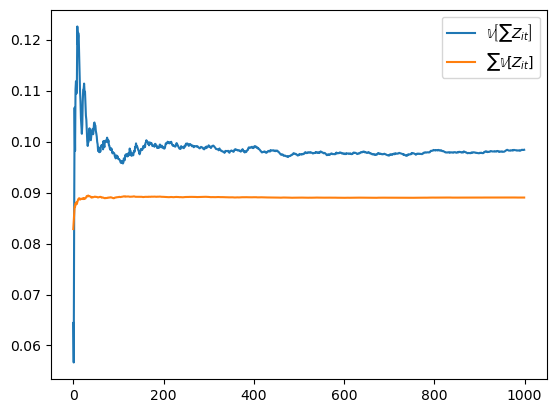

In [88]:
fig, ax = plt.subplots()
ax.plot(v1 / len(y_val), label=r"$\mathbb{V}\left[\sum Z_{it}\right]$")
ax.plot(v2 / len(y_val), label=r"$\sum\mathbb{V}[Z_{it}]$")
ax.legend()
plt.show()

## Case 2: Test data is sampled and the same forest is used to predict over them
Here, randomness in $Z_{it}$ is introduced by the test data *only*.

$Z_{it} = f(X_i)$

In [96]:
rf = ExtraTreesClassifier(n_estimators=10).fit(X_train, y_train)
scores_on_instances = []
for seed in tqdm(range(10**5)):
    X_val_, y_val_ = get_random_dataset(100, d=d, k=k)
    scores_on_instances.append(((rf.predict_proba(X_val_) - get_one_hot_encoding(y_val_))**2).sum(axis=1))
scores_on_instances = np.array(scores_on_instances)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [97]:
v1 = []
v2 = []
for i in tqdm(range(10, len(scores_on_instances) + 1, 100)):
    v1.append(scores_on_instances[:i].sum(axis=1).var())
    v2.append(scores_on_instances[:i].var(axis=0).sum())
v1 = np.array(v1)
v2 = np.array(v2)

  0%|          | 0/1000 [00:00<?, ?it/s]

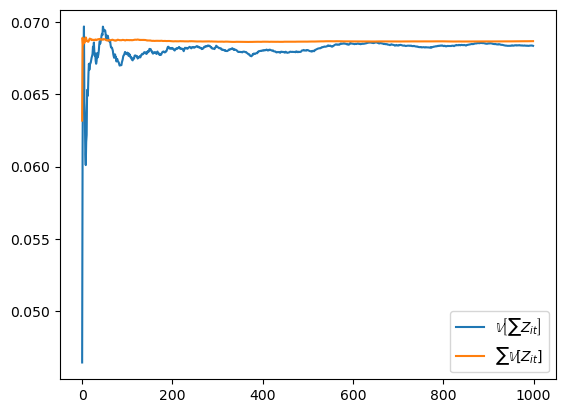

In [98]:
fig, ax = plt.subplots()
ax.plot(v1 / len(y_val), label=r"$\mathbb{V}\left[\sum Z_{it}\right]$")
ax.plot(v2 / len(y_val), label=r"$\sum\mathbb{V}[Z_{it}]$")
ax.legend()
plt.show()

# Conclusion
The terms $Z_{it}$ are *not* independent across different $i$s (even though the X *are* independent).